In [12]:
library(rstan)
library(brms)
library(here)
library(bayesplot)
library(ggfortify)
library(gridExtra)
source(here("plotSSM.r"), encoding = "utf-8")

# 計算の高速化
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


In [3]:
sales_df_2 <- read.csv(here("data", "5-4-1-sales-ts-2.csv"))
sales_df_2$date <- as.POSIXct(sales_df_2$date)
head(sales_df_2, n = 3)


,date,sales,publicity
,<dttm>,<dbl>,<int>
1,2010-01-01,95.8,0
2,2010-01-02,83.6,0
3,2010-01-03,94.1,0


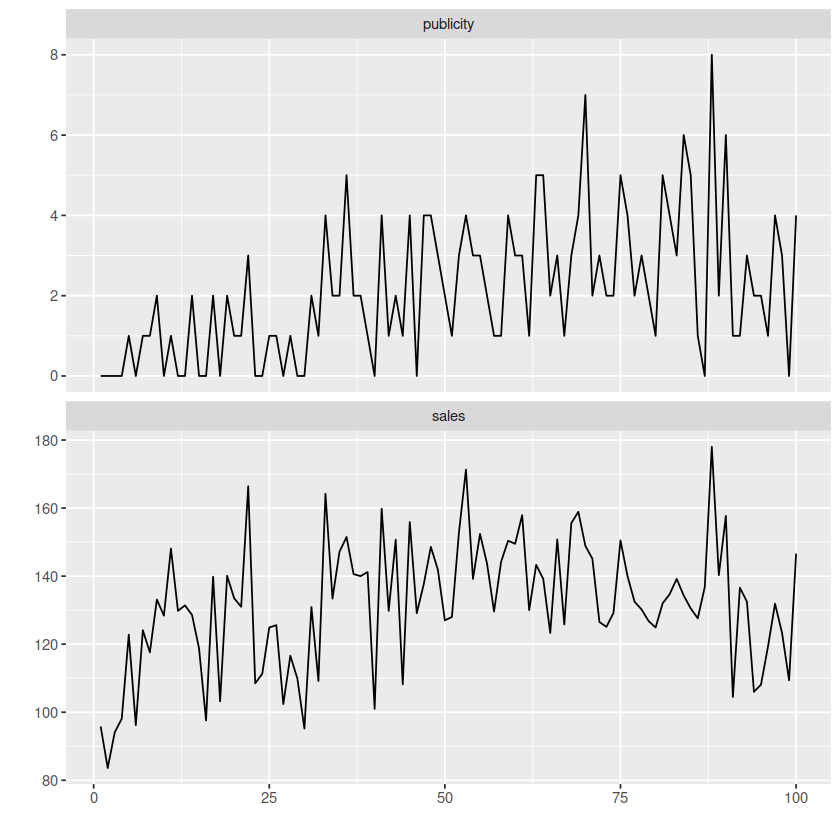

In [4]:
autoplot(ts(sales_df_2[, -1]))


In [5]:
mod_lm <- brm(
  formula = sales ~ publicity,
  family = gaussian(link = "identity"),
  data = sales_df_2,
  seed = 1
)


Compiling Stan program...

Start sampling



In [6]:
fixef(mod_lm)


,Estimate,Est.Error,Q2.5,Q97.5
Intercept,115.948441,2.1692896,111.624393,120.248429
publicity,7.372735,0.7818055,5.873922,8.934349


In [7]:
# 最初の50日と後半の50日で区切ってそれぞれモデルにしてみる
sales_df_2_head <- head(sales_df_2, n = 50)
sales_df_2_tail <- tail(sales_df_2, n = 50)
# 前半のモデル化
mod_lm_head <- brm(
  formula = sales ~ publicity,
  family = gaussian(link = "identity"),
  data = sales_df_2_head,
  seed = 1
)

# 後半のモデル化
mod_lm_tail <- brm(
  formula = sales ~ publicity,
  family = gaussian(link = "identity"),
  data = sales_df_2_tail,
  seed = 1
)


Compiling Stan program...

Start sampling

Compiling Stan program...

Start sampling



In [8]:
fixef(mod_lm_head)


,Estimate,Est.Error,Q2.5,Q97.5
Intercept,110.75132,2.536796,105.797146,115.80230
publicity,11.63067,1.361873,8.943989,14.26685


In [9]:
fixef(mod_lm_tail)


,Estimate,Est.Error,Q2.5,Q97.5
Intercept,122.224487,3.517546,115.162486,129.157462
publicity,5.070656,1.042341,3.079946,7.112264


In [15]:
data_list <- list(
  y = sales_df_2$sales,
  ex = sales_df_2$publicity,
  T = nrow(sales_df_2)
)
time_varying_coef_stan <- stan(
  file = here("5部", "5-4-time-varying-coef.stan"),
  data = data_list,
  seed = 1,
  iter = 8000,
  warmup = 2000,
  thin = 6
)


Warning message in readLines(file, warn = TRUE):
“'/media/e595/Game/プロジェクト置き場/RとStanで始めるベイズ統計モデリング/5部/5-4-time-varying-coef.stan' で不完全な最終行が見つかりました”


Warning message:
“There were 2 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


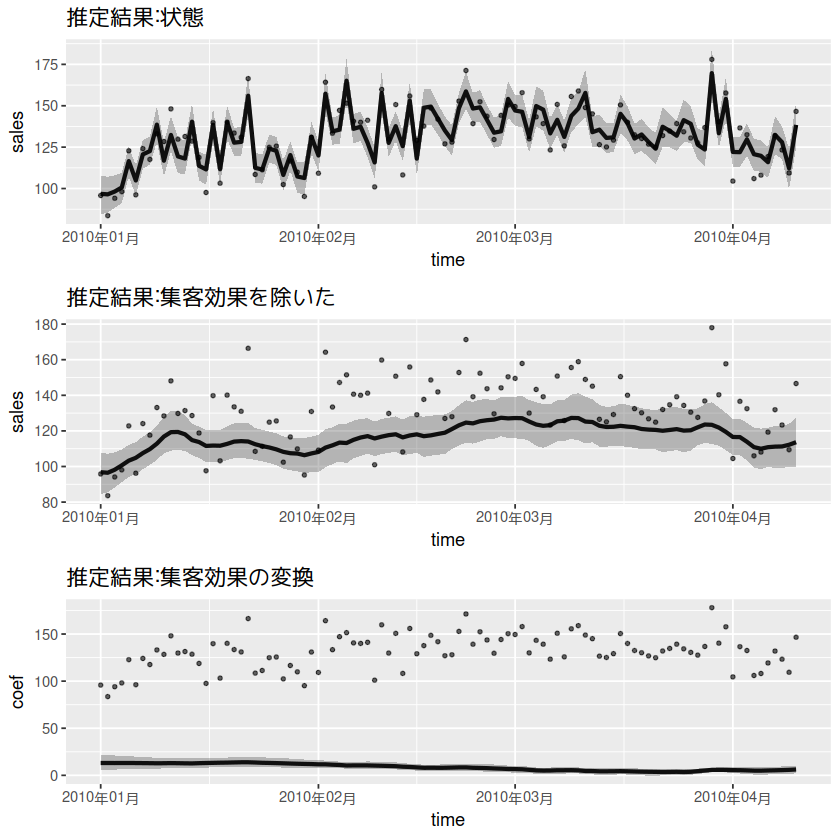

In [16]:
mcmc_sample <- rstan::extract(time_varying_coef_stan)

p_all <- plotSSM(
  mcmc_sample = mcmc_sample,
  time_vec = sales_df_2$date,
  obs_vec = sales_df_2$sales,
  state_name = "alpha",
  graph_title = "推定結果:状態",
  y_label = "sales"
)

p_mu <- plotSSM(
  mcmc_sample = mcmc_sample,
  time_vec = sales_df_2$date,
  obs_vec = sales_df_2$sales,
  state_name = "mu",
  graph_title = "推定結果:集客効果を除いた",
  y_label = "sales"
)
p_b <- plotSSM(
  mcmc_sample = mcmc_sample,
  time_vec = sales_df_2$date,
  obs_vec = sales_df_2$sales,
  state_name = "b",
  graph_title = "推定結果:集客効果の変換",
  y_label = "coef"
)

grid.arrange(p_all, p_mu, p_b)
